<a href="https://colab.research.google.com/github/OlegPozovnoy/MailRuNLP/blob/master/HW5/homework04_basic_part2_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [207]:
from google.colab import drive
drive.mount('mydrive')

Drive already mounted at mydrive; to attempt to forcibly remount, call drive.mount("mydrive", force_remount=True).


In [208]:
!ls 'mydrive/My Drive/datasets/'

captions_tokenized.json  image_codes.npy


### Data preprocessing

In [23]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("mydrive/My Drive/datasets/image_codes.npy")
captions = json.load(open('mydrive/My Drive/datasets/captions_tokenized.json'))

CPU times: user 476 ms, sys: 660 ms, total: 1.14 s
Wall time: 1.83 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [24]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [25]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [209]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
      for word_i in range(len(captions[img_i][caption_i])):
        word_counts[captions[img_i][caption_i][word_i]]+=1



In [210]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}



In [211]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [29]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [212]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [59]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, num_layers=1, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [213]:

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
network = CaptionNet(n_tokens).to(device)
device

device(type='cuda', index=0)

In [215]:
dummy_img_vec = torch.randn(len(captions[0]), 2048).to(device)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64).to(device)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [216]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
        
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    #print(captions_ix_next != pad_ix)

    #print('logit',logits_for_next[0].shape)
    #print('caption',captions_ix_next[0].shape)
    #loss_func = nn.LogSoftmax(dim=2)
    #logits_for_next = loss_func(logits_for_next)

    #print('logit',logits_for_next[0])
    #print('caption',captions_ix_next[0])
    #print(logits_for_next.contiguous().view(-1, len(logits_for_next[0][0]))[0])
    #print(captions_ix_next.contiguous().view(-1))


    loss_func = nn.CrossEntropyLoss(ignore_index = pad_ix)
    loss = loss_func(logits_for_next.contiguous().view(-1, len(logits_for_next[0][0])),
                 captions_ix_next.contiguous().view(-1))
    #loss = loss_func(logits_for_next, captions_ix_next)
    #print('loss', loss)
    #print('target', torch.Size([1]))
    return loss

In [220]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

print(dummy_img_vec.shape, dummy_capt_ix.shape)

print(dummy_loss.shape)

#assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

torch.Size([5, 2048]) torch.Size([5, 16])
torch.Size([])


Create ~~adam~~ your favorite optimizer for the network.

In [221]:
opt = torch.optim.AdamW(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [227]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)



In [229]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device), torch.tensor(batch_captions_ix, dtype=torch.int64).to(device)
    

In [230]:
generate_batch(img_codes,captions,3)

(tensor([[0.3576, 0.5385, 0.6199,  ..., 0.1969, 0.3105, 0.1667],
         [0.0072, 0.3928, 0.0810,  ..., 0.2030, 0.1290, 0.5076],
         [0.1072, 0.1663, 0.3635,  ..., 0.0109, 0.2168, 0.5049]],
        device='cuda:0'),
 tensor([[   1,   24,  262,   58,   24,  289,   17,   38,   31,   45,   97,   58,
            24,  131, 1015,  590,   45, 2503,  274,   12,    2],
         [   1,    7,  101,  208, 1176,  193,  117,   24,  268,    6,   45,  209,
             2,    3,    3,    3,    3,    3,    3,    3,    3],
         [   1,   24,  180,   15,   88, 1970, 4833,    6,   24,   64,  141,   12,
             2,    3,    3,    3,    3,    3,    3,    3,    3]],
        device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [233]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 500  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [234]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  2%|▏         | 9/500 [00:00<00:05, 85.54it/s]


Epoch: 0, train loss: 2.6205213375091554, val loss: 2.57780179977417


  2%|▏         | 9/500 [00:00<00:05, 88.15it/s]


Epoch: 1, train loss: 2.590832605838776, val loss: 2.5968796253204345


  2%|▏         | 9/500 [00:00<00:05, 87.36it/s]


Epoch: 2, train loss: 2.5772474513053893, val loss: 2.619071626663208


  2%|▏         | 9/500 [00:00<00:05, 85.94it/s]


Epoch: 3, train loss: 2.553430844783783, val loss: 2.753944826126099


  2%|▏         | 9/500 [00:00<00:05, 82.14it/s]


Epoch: 4, train loss: 2.5502387728691103, val loss: 2.6448988914489746


  2%|▏         | 9/500 [00:00<00:05, 86.67it/s]


Epoch: 5, train loss: 2.5229642810821535, val loss: 2.587729740142822


  2%|▏         | 8/500 [00:00<00:06, 78.82it/s]


Epoch: 6, train loss: 2.5169029693603515, val loss: 2.65800142288208


  2%|▏         | 9/500 [00:00<00:05, 86.87it/s]


Epoch: 7, train loss: 2.502862268924713, val loss: 2.5201509952545167


  2%|▏         | 9/500 [00:00<00:06, 76.70it/s]


Epoch: 8, train loss: 2.488929542541504, val loss: 2.360514497756958


  2%|▏         | 9/500 [00:00<00:05, 84.28it/s]


Epoch: 9, train loss: 2.497684944152832, val loss: 2.6253406524658205


  2%|▏         | 9/500 [00:00<00:06, 81.55it/s]


Epoch: 10, train loss: 2.463780391216278, val loss: 2.533881998062134


  2%|▏         | 10/500 [00:00<00:05, 85.73it/s]


Epoch: 11, train loss: 2.4549695999622343, val loss: 2.5828032970428465


  2%|▏         | 9/500 [00:00<00:05, 89.84it/s]


Epoch: 12, train loss: 2.443832322597504, val loss: 2.523270845413208


  2%|▏         | 10/500 [00:00<00:05, 93.85it/s]


Epoch: 13, train loss: 2.433954303741455, val loss: 2.508922576904297


  2%|▏         | 9/500 [00:00<00:05, 87.21it/s]


Epoch: 14, train loss: 2.42503151845932, val loss: 2.581772232055664


  2%|▏         | 9/500 [00:00<00:05, 86.25it/s]


Epoch: 15, train loss: 2.4172515640258787, val loss: 2.558066701889038


  2%|▏         | 9/500 [00:00<00:05, 89.27it/s]


Epoch: 16, train loss: 2.4163135805130005, val loss: 2.518421697616577


  2%|▏         | 9/500 [00:00<00:05, 84.25it/s]


Epoch: 17, train loss: 2.398345359802246, val loss: 2.4031889915466307


  2%|▏         | 9/500 [00:00<00:05, 89.63it/s]


Epoch: 18, train loss: 2.3979294335842134, val loss: 2.423172426223755


  2%|▏         | 9/500 [00:00<00:05, 88.74it/s]


Epoch: 19, train loss: 2.3957829661369323, val loss: 2.4051040172576905


  2%|▏         | 10/500 [00:00<00:05, 91.66it/s]


Epoch: 20, train loss: 2.3849357328414915, val loss: 2.487608528137207


  2%|▏         | 8/500 [00:00<00:06, 72.70it/s]


Epoch: 21, train loss: 2.376305133342743, val loss: 2.533029651641846


  2%|▏         | 9/500 [00:00<00:06, 80.40it/s]


Epoch: 22, train loss: 2.3789607396125794, val loss: 2.4101897716522216


  2%|▏         | 10/500 [00:00<00:05, 89.12it/s]


Epoch: 23, train loss: 2.3682736513614655, val loss: 2.4917987823486327


  2%|▏         | 9/500 [00:00<00:05, 82.78it/s]


Epoch: 24, train loss: 2.3662234287261965, val loss: 2.311867523193359


  2%|▏         | 9/500 [00:00<00:05, 83.48it/s]


Epoch: 25, train loss: 2.352217346429825, val loss: 2.3514243602752685


  2%|▏         | 9/500 [00:00<00:05, 87.52it/s]


Epoch: 26, train loss: 2.3548145837783814, val loss: 2.4150936126708986


  2%|▏         | 8/500 [00:00<00:06, 79.97it/s]


Epoch: 27, train loss: 2.350645390033722, val loss: 2.526972246170044


  2%|▏         | 10/500 [00:00<00:05, 90.50it/s]


Epoch: 28, train loss: 2.3466603507995605, val loss: 2.421136808395386


  2%|▏         | 9/500 [00:00<00:06, 80.29it/s]


Epoch: 29, train loss: 2.3389854924678803, val loss: 2.5062265396118164


  2%|▏         | 9/500 [00:00<00:06, 80.89it/s]


Epoch: 30, train loss: 2.3274953196048735, val loss: 2.5159301280975344


  2%|▏         | 10/500 [00:00<00:05, 90.93it/s]


Epoch: 31, train loss: 2.319852165222168, val loss: 2.3846740245819094


  2%|▏         | 10/500 [00:00<00:05, 91.40it/s]


Epoch: 32, train loss: 2.322928144454956, val loss: 2.4768561840057375


  2%|▏         | 10/500 [00:00<00:05, 92.93it/s]


Epoch: 33, train loss: 2.3240552842617035, val loss: 2.5028835773468017


  2%|▏         | 9/500 [00:00<00:05, 82.97it/s]


Epoch: 34, train loss: 2.3110636637210846, val loss: 2.5055931568145753


  2%|▏         | 9/500 [00:00<00:06, 80.66it/s]


Epoch: 35, train loss: 2.316490784883499, val loss: 2.385402488708496


  2%|▏         | 9/500 [00:00<00:05, 82.15it/s]


Epoch: 36, train loss: 2.3227795963287354, val loss: 2.364036512374878


  2%|▏         | 9/500 [00:00<00:05, 89.01it/s]


Epoch: 37, train loss: 2.3168567073345185, val loss: 2.4257471561431885


  2%|▏         | 9/500 [00:00<00:06, 80.83it/s]


Epoch: 38, train loss: 2.304680056810379, val loss: 2.5420248031616213


  2%|▏         | 8/500 [00:00<00:06, 78.70it/s]


Epoch: 39, train loss: 2.2922780635356905, val loss: 2.507088851928711


  2%|▏         | 8/500 [00:00<00:06, 76.67it/s]


Epoch: 40, train loss: 2.3005066514015198, val loss: 2.410408878326416


  2%|▏         | 8/500 [00:00<00:06, 79.51it/s]


Epoch: 41, train loss: 2.2867217752933504, val loss: 2.36374773979187


  2%|▏         | 9/500 [00:00<00:05, 83.62it/s]


Epoch: 42, train loss: 2.287508251428604, val loss: 2.363599967956543


  2%|▏         | 8/500 [00:00<00:06, 72.81it/s]


Epoch: 43, train loss: 2.2934692034721373, val loss: 2.3624836444854735


  2%|▏         | 9/500 [00:00<00:05, 87.81it/s]


Epoch: 44, train loss: 2.2913928956985474, val loss: 2.4756316184997558


  2%|▏         | 9/500 [00:00<00:05, 82.67it/s]


Epoch: 45, train loss: 2.289815118551254, val loss: 2.465228033065796


  2%|▏         | 10/500 [00:00<00:05, 92.56it/s]


Epoch: 46, train loss: 2.2806935296058657, val loss: 2.3588812828063963


  2%|▏         | 9/500 [00:00<00:05, 85.20it/s]


Epoch: 47, train loss: 2.2715195150375367, val loss: 2.3903109073638915


  2%|▏         | 8/500 [00:00<00:07, 69.24it/s]


Epoch: 48, train loss: 2.277675734758377, val loss: 2.3773678302764893


  2%|▏         | 9/500 [00:00<00:05, 88.03it/s]


Epoch: 49, train loss: 2.279752250909805, val loss: 2.34701189994812


  2%|▏         | 9/500 [00:00<00:05, 81.88it/s]


Epoch: 50, train loss: 2.262545011281967, val loss: 2.4292935848236086


  2%|▏         | 9/500 [00:00<00:06, 81.47it/s]


Epoch: 51, train loss: 2.2550543608665468, val loss: 2.3560773372650146


  2%|▏         | 9/500 [00:00<00:05, 84.01it/s]


Epoch: 52, train loss: 2.25322195315361, val loss: 2.352480983734131


  2%|▏         | 9/500 [00:00<00:06, 79.74it/s]


Epoch: 53, train loss: 2.255695043802261, val loss: 2.3985559940338135


  2%|▏         | 9/500 [00:00<00:05, 83.67it/s]


Epoch: 54, train loss: 2.260789001941681, val loss: 2.39900426864624


  2%|▏         | 9/500 [00:00<00:05, 87.33it/s]


Epoch: 55, train loss: 2.247434450864792, val loss: 2.3097159385681154


  2%|▏         | 9/500 [00:00<00:05, 83.09it/s]


Epoch: 56, train loss: 2.2459643204212187, val loss: 2.359463405609131


  2%|▏         | 9/500 [00:00<00:05, 84.23it/s]


Epoch: 57, train loss: 2.252632402420044, val loss: 2.4706706047058105


  2%|▏         | 8/500 [00:00<00:06, 73.97it/s]


Epoch: 58, train loss: 2.246329442024231, val loss: 2.4341838359832764


  2%|▏         | 9/500 [00:00<00:05, 84.49it/s]


Epoch: 59, train loss: 2.244429524898529, val loss: 2.5528756618499755


  2%|▏         | 9/500 [00:00<00:05, 88.10it/s]


Epoch: 60, train loss: 2.2326486473083498, val loss: 2.369263458251953


  2%|▏         | 9/500 [00:00<00:05, 88.09it/s]


Epoch: 61, train loss: 2.234265873432159, val loss: 2.468207359313965


  2%|▏         | 9/500 [00:00<00:05, 84.50it/s]


Epoch: 62, train loss: 2.240984671354294, val loss: 2.4377026557922363


  2%|▏         | 9/500 [00:00<00:05, 89.79it/s]


Epoch: 63, train loss: 2.2335853848457337, val loss: 2.33339147567749


  2%|▏         | 9/500 [00:00<00:06, 81.34it/s]


Epoch: 64, train loss: 2.233957579612732, val loss: 2.463695001602173


  2%|▏         | 9/500 [00:00<00:05, 89.01it/s]


Epoch: 65, train loss: 2.243265784263611, val loss: 2.3212604999542235


  2%|▏         | 9/500 [00:00<00:05, 89.89it/s]


Epoch: 66, train loss: 2.222331000804901, val loss: 2.4278988361358644


  2%|▏         | 10/500 [00:00<00:05, 88.51it/s]


Epoch: 67, train loss: 2.2291390824317934, val loss: 2.3687288761138916


  2%|▏         | 8/500 [00:00<00:06, 71.36it/s]


Epoch: 68, train loss: 2.2271733498573303, val loss: 2.4354274749755858


  2%|▏         | 8/500 [00:00<00:06, 72.73it/s]


Epoch: 69, train loss: 2.227867080450058, val loss: 2.3213876724243163


  2%|▏         | 9/500 [00:00<00:06, 79.37it/s]


Epoch: 70, train loss: 2.2132975232601164, val loss: 2.359899473190308


  2%|▏         | 9/500 [00:00<00:05, 82.53it/s]


Epoch: 71, train loss: 2.218524887561798, val loss: 2.397356653213501


  2%|▏         | 10/500 [00:00<00:05, 91.73it/s]


Epoch: 72, train loss: 2.209385972261429, val loss: 2.484687566757202


  2%|▏         | 9/500 [00:00<00:05, 87.90it/s]


Epoch: 73, train loss: 2.222649321079254, val loss: 2.4440292835235597


  2%|▏         | 9/500 [00:00<00:05, 87.06it/s]


Epoch: 74, train loss: 2.220614736557007, val loss: 2.4188051223754883


  2%|▏         | 8/500 [00:00<00:06, 74.57it/s]


Epoch: 75, train loss: 2.2123305718898774, val loss: 2.4071250438690184


  2%|▏         | 9/500 [00:00<00:05, 84.78it/s]


Epoch: 76, train loss: 2.2049416975975036, val loss: 2.2939462184906008


  2%|▏         | 8/500 [00:00<00:06, 76.95it/s]


Epoch: 77, train loss: 2.2134206273555757, val loss: 2.4787166595458983


  2%|▏         | 9/500 [00:00<00:05, 84.99it/s]


Epoch: 78, train loss: 2.214138912200928, val loss: 2.3442777156829835


  2%|▏         | 9/500 [00:00<00:06, 81.47it/s]


Epoch: 79, train loss: 2.199432621717453, val loss: 2.3503902435302733


  2%|▏         | 9/500 [00:00<00:05, 84.97it/s]


Epoch: 80, train loss: 2.2158626439571383, val loss: 2.5465850830078125


  2%|▏         | 9/500 [00:00<00:05, 89.08it/s]


Epoch: 81, train loss: 2.1937244284152984, val loss: 2.3920619964599608


  2%|▏         | 9/500 [00:00<00:05, 88.23it/s]


Epoch: 82, train loss: 2.2043871500492096, val loss: 2.366959238052368


  2%|▏         | 8/500 [00:00<00:06, 78.36it/s]


Epoch: 83, train loss: 2.202120621919632, val loss: 2.323394203186035


  2%|▏         | 8/500 [00:00<00:06, 79.67it/s]


Epoch: 84, train loss: 2.19792733669281, val loss: 2.375651979446411


  2%|▏         | 10/500 [00:00<00:05, 87.42it/s]


Epoch: 85, train loss: 2.1859141681194307, val loss: 2.3536962032318116


  2%|▏         | 8/500 [00:00<00:06, 73.42it/s]


Epoch: 86, train loss: 2.1933499376773833, val loss: 2.3331793785095214


  2%|▏         | 10/500 [00:00<00:05, 92.19it/s]


Epoch: 87, train loss: 2.1976603174209597, val loss: 2.376890230178833


  2%|▏         | 8/500 [00:00<00:06, 79.02it/s]


Epoch: 88, train loss: 2.196760477542877, val loss: 2.25248122215271


  2%|▏         | 8/500 [00:00<00:06, 76.87it/s]


Epoch: 89, train loss: 2.1967357399463654, val loss: 2.4177767753601076


  2%|▏         | 10/500 [00:00<00:05, 91.95it/s]


Epoch: 90, train loss: 2.189776997089386, val loss: 2.4105938911437987


  2%|▏         | 9/500 [00:00<00:05, 81.86it/s]


Epoch: 91, train loss: 2.1960257396697997, val loss: 2.4633118152618407


  2%|▏         | 8/500 [00:00<00:06, 74.20it/s]


Epoch: 92, train loss: 2.1866170547008514, val loss: 2.406033420562744


  2%|▏         | 9/500 [00:00<00:05, 85.80it/s]


Epoch: 93, train loss: 2.176381235599518, val loss: 2.336639404296875


  2%|▏         | 9/500 [00:00<00:06, 81.61it/s]


Epoch: 94, train loss: 2.181475483417511, val loss: 2.436820554733276


  2%|▏         | 8/500 [00:00<00:06, 76.94it/s]


Epoch: 95, train loss: 2.178796731233597, val loss: 2.4088594913482666


  2%|▏         | 9/500 [00:00<00:05, 82.37it/s]


Epoch: 96, train loss: 2.173997498989105, val loss: 2.332763338088989


  2%|▏         | 9/500 [00:00<00:05, 85.46it/s]


Epoch: 97, train loss: 2.1799781143665315, val loss: 2.349189567565918


  2%|▏         | 9/500 [00:00<00:05, 84.23it/s]


Epoch: 98, train loss: 2.1709156279563904, val loss: 2.4240469455718996


100%|██████████| 500/500 [00:06<00:00, 80.98it/s]


Epoch: 99, train loss: 2.174139227390289, val loss: 2.3903793334960937
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [235]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    

def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model


inception = beheaded_inception_v3().train(False)

KeyboardInterrupt: ignored

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [247]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.to(device), prefix_ix.to(device))[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [248]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('./data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2020-07-06 03:29:43--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.196.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-07-06 03:29:44--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.002s  

2020-07-06 03:29:44 (21.6 MB/s) - ‘data/img.jpg’ saved [54731/54731

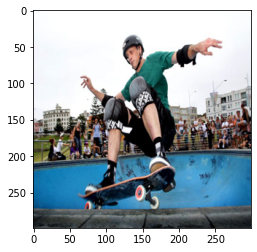

In [238]:
plt.imshow(img)

In [249]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on top of a cement block .
a man riding a skateboard on top of a cement block .
a man riding a skateboard on top of a cement block .
a man on a skateboard does a trick on a ramp .
a man on a skateboard performs a trick on a ramp .
a man riding a skateboard on top of a cement block .
a man riding a skateboard on top of a cement block .
a man on a skateboard in the air on a ramp .
a man riding a skateboard on top of a cement block .
a man on a skateboard is jumping over a ramp .


--2020-07-06 03:30:01--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-07-06 03:30:02--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   166KB/s    in 0.6s    

2020-07-06 03:30:03 (166 KB/s) - ‘data/img.jpg’ saved [106870/106870]



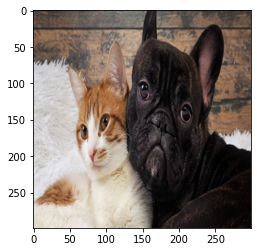

a cat sitting on top of a wooden chair .
a black and white cat sitting on a wooden chair .
a black and white cat sitting on top of a red chair .
a black and white cat sitting on a chair .
a black and white cat sitting on a chair .
a cat is sitting on a chair in a room .
a black and white cat is sitting on a chair
a black and white cat sitting on a table .
a black and white cat sitting on a chair .
a black and white cat sitting on a chair


In [250]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

--2020-07-06 03:30:16--  http://chessintweets.com/wp-content/uploads/2014/11/Converted_file_745ffa5d.jpg
Resolving chessintweets.com (chessintweets.com)... 81.169.145.163, 2a01:238:20a:202:1163::
Connecting to chessintweets.com (chessintweets.com)|81.169.145.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102486 (100K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 100.08K  47.8KB/s    in 2.1s    

2020-07-06 03:30:19 (47.8 KB/s) - ‘data/img.jpg’ saved [102486/102486]



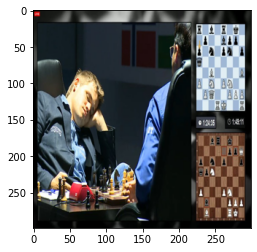

a man in a suit and tie holding a microphone .
a man in a suit and tie holding a microphone .
a man in a suit and a tie standing next to a woman .
a man in a suit and tie holding a microphone .
a man and woman standing next to a table with a laptop .
a man in a suit is standing next to a woman in a restaurant .
a man and a woman standing next to each other .
a man in a suit holding a cell phone in his hands .
a man is sitting at a table with a laptop .
a man and a woman standing next to a table with wine glasses .


In [251]:
# apply your network on images you've found
#
#
!wget http://chessintweets.com/wp-content/uploads/2014/11/Converted_file_745ffa5d.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:30:39--  https://i.ytimg.com/vi/bE1ZTODDlWg/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.24.119, 2404:6800:4003:c03::77
Connecting to i.ytimg.com (i.ytimg.com)|74.125.24.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125152 (122K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 122.22K  --.-KB/s    in 0.001s  

2020-07-06 03:30:39 (137 MB/s) - ‘data/img.jpg’ saved [125152/125152]



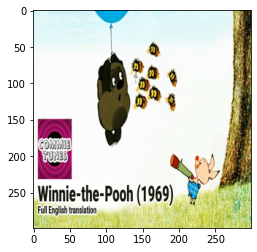

a pair of scissors and a pair of scissors on a table .
a person standing on a skateboard on a street .
a person holding a surf board on a snowy surface
a group of people standing on top of a snow covered field .
a person holding a skateboard on a street .
a pair of scissors sitting on top of a wooden table .
a person holding a surf board on a city street
a pair of scissors and a pair of scissors .
a person standing on a skateboard in the air .
a pair of scissors and a pair of scissors .


In [252]:
# apply your network on images you've found
#
#
!wget https://i.ytimg.com/vi/bE1ZTODDlWg/maxresdefault.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:31:12--  https://4tololo.ru/files/images/20181703125314.jpg
Resolving 4tololo.ru (4tololo.ru)... 92.42.15.180
Connecting to 4tololo.ru (4tololo.ru)|92.42.15.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230486 (225K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 225.08K   227KB/s    in 1.0s    

2020-07-06 03:31:15 (227 KB/s) - ‘data/img.jpg’ saved [230486/230486]



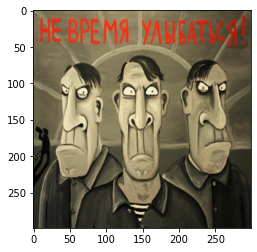

a man standing next to a white and blue sign .
a picture of a man and a woman in a white dress .
a man sitting on a bench next to a woman .
a picture of a man in a suit and hat .
a man is sitting on a bench next to a woman .
a man sitting on a bench next to a woman .
a man sitting on a bench with a backpack on the back .
a person sitting on a bench with a backpack on the side .
a man is sitting on a bench with a backpack .
a picture of a man with a hat on his back .


In [253]:
# apply your network on images you've found
#
#
!wget https://4tololo.ru/files/images/20181703125314.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:31:35--  https://d2j1wkp1bavyfs.cloudfront.net/wp-content/uploads/2019/07/Mask-06.jpg
Resolving d2j1wkp1bavyfs.cloudfront.net (d2j1wkp1bavyfs.cloudfront.net)... 13.35.18.67, 13.35.18.217, 13.35.18.186, ...
Connecting to d2j1wkp1bavyfs.cloudfront.net (d2j1wkp1bavyfs.cloudfront.net)|13.35.18.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240395 (235K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 234.76K  --.-KB/s    in 0.008s  

2020-07-06 03:31:36 (28.6 MB/s) - ‘data/img.jpg’ saved [240395/240395]



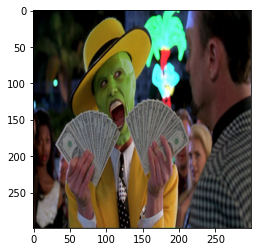

a close up of a person holding a kite
a close up of a person holding a kite
a close up of a person holding a cell phone
a close up of a person holding a cell phone
a close up of a person holding a blue and white striped umbrella .
a close up of a person holding a cell phone
a close up of a person holding a cell phone
a close up of a person holding a large purple frisbee .
a close up of a person holding a purple umbrella
a close up of a person holding a kite


In [254]:
# apply your network on images you've found
#
#
!wget https://d2j1wkp1bavyfs.cloudfront.net/wp-content/uploads/2019/07/Mask-06.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:31:54--  https://cdn.pastemagazine.com/www/articles/Highlander-header.jpg
Resolving cdn.pastemagazine.com (cdn.pastemagazine.com)... 23.199.140.232
Connecting to cdn.pastemagazine.com (cdn.pastemagazine.com)|23.199.140.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 442364 (432K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 432.00K  --.-KB/s    in 0.09s   

2020-07-06 03:31:54 (4.72 MB/s) - ‘data/img.jpg’ saved [442364/442364]



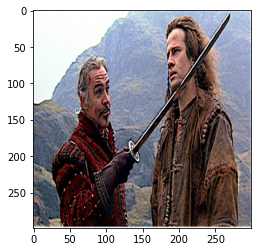

a woman in a dress is holding a cell phone .
a woman in a hat and a hat is sitting on a bench .
a woman in a hat and glasses is sitting on a bench .
a woman in a dress is holding a cell phone .
a man and a woman standing next to a woman .
a woman in a dress holding a cell phone .
a woman standing in a dress holding a cell phone .
a woman in a dress holding a cell phone .
a woman with a hat on her face is holding a cell phone .
a man and a woman are standing next to a woman .


In [255]:
# apply your network on images you've found
#
#
!wget https://cdn.pastemagazine.com/www/articles/Highlander-header.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:32:12--  https://akns-images.eonline.com/eol_images/Entire_Site/2015527/rs_600x600-150627165438-600.KanyeWest3-jmd-062715.jpg
Resolving akns-images.eonline.com (akns-images.eonline.com)... 184.84.49.151, 2600:1417:3f:6ac::1297, 2600:1417:3f:6a0::1297
Connecting to akns-images.eonline.com (akns-images.eonline.com)|184.84.49.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155819 (152K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 152.17K  --.-KB/s    in 0.1s    

2020-07-06 03:32:14 (1.31 MB/s) - ‘data/img.jpg’ saved [155819/155819]



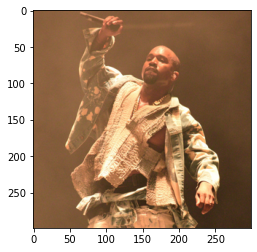

a woman with a cell phone in her hand .
a woman holding a cell phone in her hand .
a woman in a dress holding a cell phone .
a woman in a dress shirt and tie holding a pink umbrella .
a woman in a dress holding a cell phone .
a woman in a dress is holding a cell phone .
a woman with a handbag and a tie on a cell phone .
a woman in a dress holding a cell phone .
a woman in a dress holding a cell phone .
a woman holding a cell phone in her hand .


In [256]:
# apply your network on images you've found
#
#
!wget https://akns-images.eonline.com/eol_images/Entire_Site/2015527/rs_600x600-150627165438-600.KanyeWest3-jmd-062715.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:32:27--  https://upload.wikimedia.org/wikipedia/commons/8/80/Statue_of_Freddie_Mercury_in_Montreux_2005-07-15.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3807170 (3.6M) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]   3.63M  2.13MB/s    in 1.7s    

2020-07-06 03:32:30 (2.13 MB/s) - ‘data/img.jpg’ saved [3807170/3807170]



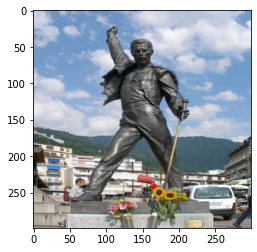

a man on a skateboard in the air on a ramp .
a man riding a skateboard down a ramp .
a man in a black shirt is doing a trick on a skateboard
a man is jumping in the air on a skateboard .
a man on a skateboard is doing a trick .
a man riding a skateboard down the side of a ramp .
a man is jumping a skateboard on a ramp .
a man riding a skateboard down the side of a ramp .
a man riding a skateboard on top of a cement block .
a man riding a skateboard down a street .


In [257]:
# apply your network on images you've found
#
#
!wget https://upload.wikimedia.org/wikipedia/commons/8/80/Statue_of_Freddie_Mercury_in_Montreux_2005-07-15.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:32:45--  https://storage.googleapis.com/kaggle-datasets-images/144468/337794/1ad8516fa7ee2c9eadfbdda2b62a7b20/data-original.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 74.125.68.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 514826 (503K) [application/octet-stream]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 502.76K  --.-KB/s    in 0.003s  

2020-07-06 03:32:45 (142 MB/s) - ‘data/img.jpg’ saved [514826/514826]



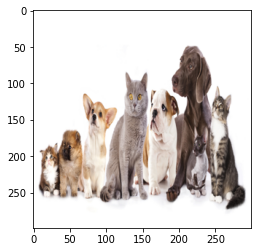

a cat sitting on top of a white and brown horse .
a cat is sitting on a white and black dog
a cat is sitting on a white and black dog
a cat is sitting on a white and black dog
a cat sitting on top of a white and brown horse .
a dog sitting on a bed with a stuffed animal .
a cat is sitting on the back of a white and brown horse .
a dog is sitting on the back of a chair .
a cat is sitting on a white and black dog
a cat sitting on the back of a white and brown dog .


In [258]:
# apply your network on images you've found
#
#
!wget https://storage.googleapis.com/kaggle-datasets-images/144468/337794/1ad8516fa7ee2c9eadfbdda2b62a7b20/data-original.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:33:00--  https://i.stack.imgur.com/b8qzD.jpg
Resolving i.stack.imgur.com (i.stack.imgur.com)... 104.16.1.35, 104.16.25.34, 104.16.28.34, ...
Connecting to i.stack.imgur.com (i.stack.imgur.com)|104.16.1.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 213752 (209K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 208.74K  --.-KB/s    in 0.005s  

2020-07-06 03:33:00 (41.0 MB/s) - ‘data/img.jpg’ saved [213752/213752]



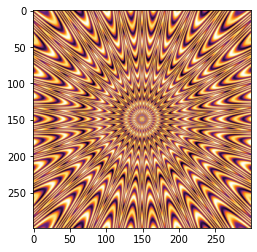

a large vase filled with lots of flowers .
a bunch of umbrellas are hanging from a ceiling .
a large vase filled with lots of flowers .
a bunch of umbrellas are hanging from a ceiling .
a bunch of umbrellas are hanging from a ceiling .
a bunch of umbrellas hanging from a ceiling .
a bunch of flowers in a vase on a table .
a bunch of umbrellas are hanging from a ceiling .
a bunch of umbrellas are hanging from a ceiling .
a bunch of umbrellas are hanging from a ceiling .


In [259]:
# apply your network on images you've found
#
#
!wget https://i.stack.imgur.com/b8qzD.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-07-06 03:33:20--  https://images.glaciermedia.ca/polopoly_fs/1.24113842.1586235134!/fileImage/httpImage/image.jpg_gen/derivatives/landscape_804/b5-0407-swimhedlin-clr-jpg.jpg
Resolving images.glaciermedia.ca (images.glaciermedia.ca)... 45.60.66.112
Connecting to images.glaciermedia.ca (images.glaciermedia.ca)|45.60.66.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207227 (202K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 202.37K  --.-KB/s    in 0.007s  

2020-07-06 03:33:21 (29.2 MB/s) - ‘data/img.jpg’ saved [207227/207227]



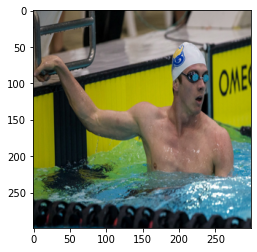

a man in a hat is standing next to a large elephant .
a man in a hat is holding a banana .
a man in a hat is holding a banana .
a man in a hat is standing next to a large elephant .
a man in a hat is holding a banana .
a man in a hat is holding a banana .
a man in a hat is holding a banana .
a man in a hat is holding a banana .
a man in a hat is holding a banana .
a man in a hat is standing in front of a large vase .


In [260]:
# apply your network on images you've found
#
#
!wget https://images.glaciermedia.ca/polopoly_fs/1.24113842.1586235134!/fileImage/httpImage/image.jpg_gen/derivatives/landscape_804/b5-0407-swimhedlin-clr-jpg.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)